# Signal processing

## Assignment 4

### Dimitrije Zdrale and Marija Brkic

TO DO: DENOISING IN THE STFT DOMAIN

**STFT**

Short-Time Fourier Transform (STFT) is defined as its correlation with the time-frequency atom $\phi_{\tau,\nu}(t) = w(t-\tau)e^{i2\pi \nu t}$:

$$
X(\tau,\nu) = \langle x, \phi_{\tau,\nu} \rangle = \int_{-\infty}^{\infty} x(t)w(t-\tau)e^{i2\pi \nu t}dt
$$

Descrete STFT is given by:

$$
X[\tau,\nu] = \sum_{t=0}^{N-1} x[t]w[t-a\tau]e^{i\frac{2\pi \nu}{M}t}
$$

where $a>0$, and $M\geq N$ (usually $M=L$ or $M=2L$).

Adding Noise:

- Noisy signal: $y = x + n$ where $x$ is clean signal and $n$ is additive noise
- In STFT domain: $Y[\tau, \nu] = X[\tau, \nu] + N[\tau, \nu]$
- Power expectation: $\mathbb{E}\{|Y[\tau, \nu]|^2\} = |X[\tau, \nu]|^2 + S_n[\nu]$

**Denoising Methods:**

**1. Hard Thresholding:**
$$\hat{X}(\tau, \nu) = \begin{cases} 
Y(\tau, \nu) & \text{if } |Y(\tau, \nu)| > \lambda |S_n(\nu)| \\
0 & \text{if } |Y(\tau, \nu)| \leq \lambda |S_n(\nu)|
\end{cases}$$

**2. Spectral Subtraction:**
$$\hat{X}(\tau, \nu) = Y(\tau, \nu)\left(1 - \frac{\lambda^2 |S_n(\nu)|^2}{|Y(\tau, \nu)|^2}\right)^+$$

where $(.)^+$ denotes the positive part function.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import stft, istft
from scipy.signal.windows import hann
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10


In [2]:

noise_files = ['data/noise1.wav', 'data/noise2.wav', 'data/noise3.wav']
clean_file = 'data/string_1.wav'

noise_signals = []
sample_rates = []


for i, file_path in enumerate(noise_files):
    try:
        fs, signal = wav.read(file_path) 
        signal = signal.astype(np.float64)
        noise_signals.append(signal)
        sample_rates.append(fs)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

try:
    fs_clean, clean_signal = wav.read(clean_file)
    clean_signal = clean_signal.astype(np.float64)
except Exception as e:
    print(f"Error loading clean signal: {e}")


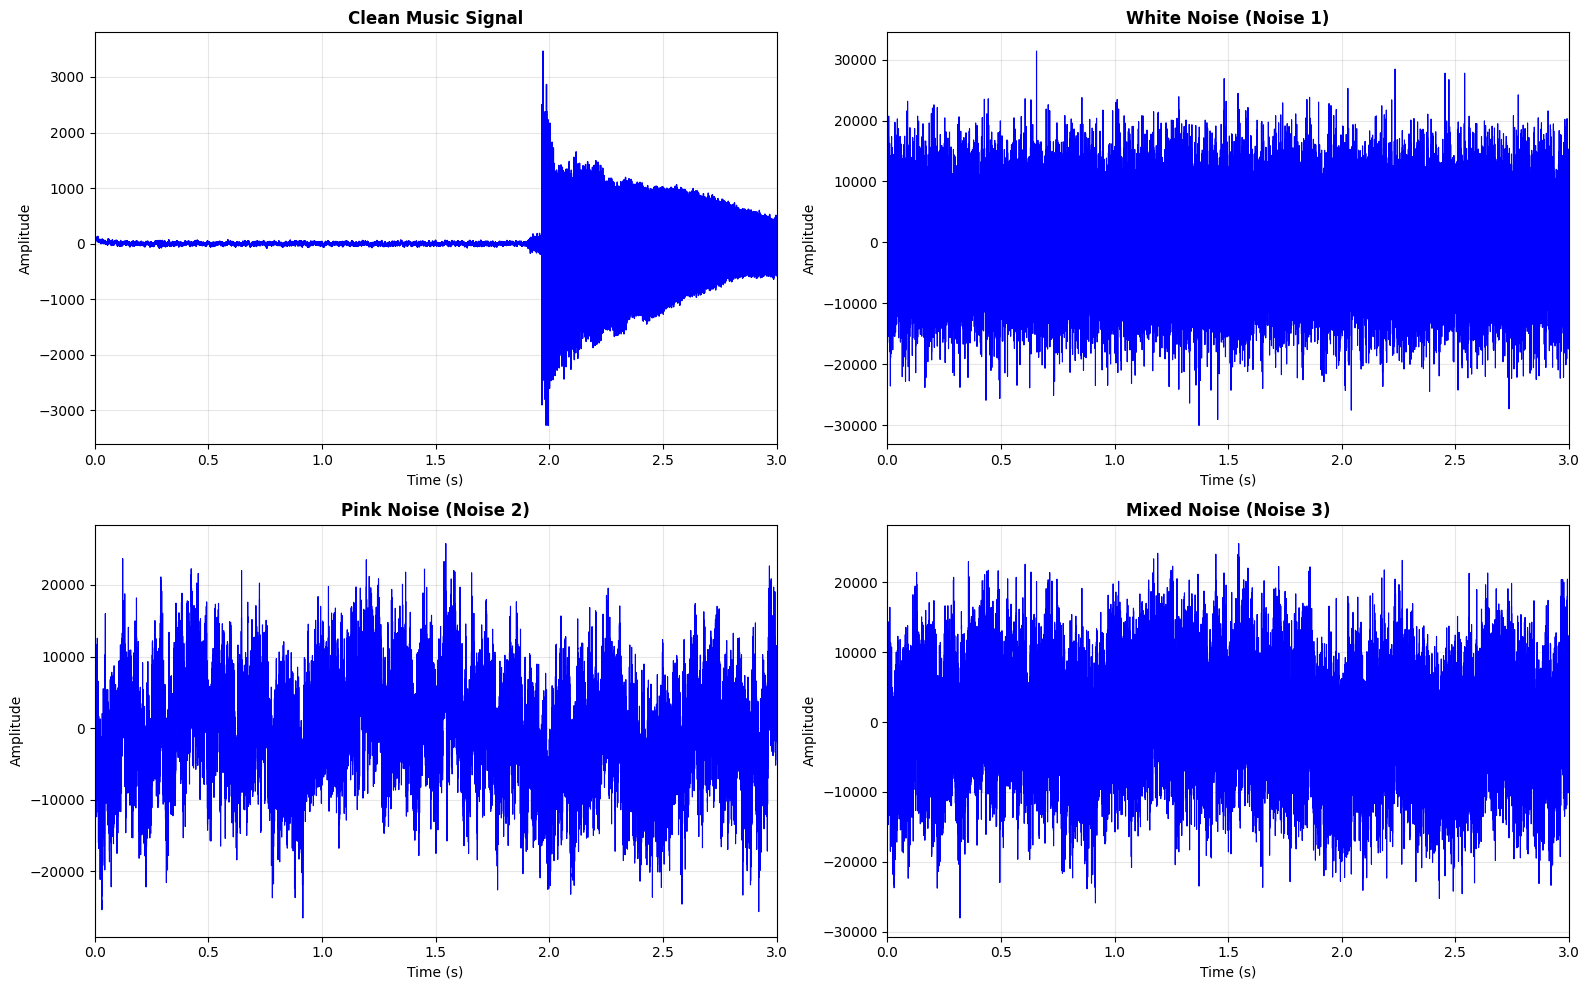

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

plot_duration = 3.0 
noise_types = ['White Noise', 'Pink Noise', 'Mixed Noise']

plot_samples_clean = min(int(plot_duration * fs_clean), len(clean_signal))
time_clean = np.arange(plot_samples_clean) / fs_clean

axes[0, 0].plot(time_clean, clean_signal[:plot_samples_clean], 'b-', linewidth=1)
axes[0, 0].set_title('Clean Music Signal', fontweight='bold')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, plot_duration)


for i, (noise, fs, noise_type) in enumerate(zip(noise_signals, sample_rates, noise_types)):
    if i < 3: 
        row = (i + 1) // 2
        col = (i + 1) % 2
        
        plot_samples_noise = min(int(plot_duration * fs), len(noise))
        time_noise = np.arange(plot_samples_noise) / fs
        
        axes[row, col].plot(time_noise, noise[:plot_samples_noise], 'b-', linewidth=0.8)
        axes[row, col].set_title(f'{noise_type} (Noise {i+1})', fontweight='bold')
        axes[row, col].set_xlabel('Time (s)')
        axes[row, col].set_ylabel('Amplitude')
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_xlim(0, plot_duration)

plt.tight_layout()
plt.show()

Simulate Noisy Versions at Various SNR Levels

Signal to Noise Ratio (SNR)
$$\text{SNR}_{dB} = 20 \log_{10} \left( \frac{\|x\|}{\|y - x\|} \right) \text{ dB} = 10\log_{10} \left( \frac{P_{\text{signal}}}{P_{\text{noise}}} \right) \text{ dB}$$

where $P_{\text{signal}}$ and $P_{\text{noise}}$ are the signal and noise powers, respectively.

In [4]:
def calculate_snr(clean_signal, noisy_signal):
    noise = noisy_signal - clean_signal
    signal_norm = np.linalg.norm(clean_signal)  
    noise_norm = np.linalg.norm(noise)     
    
    if noise_norm == 0:
        return float('inf')
    
    snr_db = 20 * np.log10(signal_norm / noise_norm)  
    return snr_db

def add_noise_at_snr(clean_signal, noise_signal, target_snr_db):
    if len(noise_signal) < len(clean_signal):
        repeats = int(np.ceil(len(clean_signal) / len(noise_signal)))
        noise_extended = np.tile(noise_signal, repeats)
    else:
        noise_extended = noise_signal.copy()
    
    noise_truncated = noise_extended[:len(clean_signal)]
    
    # to check
    signal_power = np.mean(clean_signal**2)
    noise_power = np.mean(noise_truncated**2)

    # SNR = 10 * log10(P_signal / P_noise_scaled)
    # P_noise_scaled = P_signal / 10^(SNR/10)
    target_noise_power = signal_power / (10 ** (target_snr_db / 10))
    scaling_factor = np.sqrt(target_noise_power / noise_power)
    
    scaled_noise = noise_truncated * scaling_factor
    noisy_signal = clean_signal + scaled_noise
    actual_snr = calculate_snr(clean_signal, noisy_signal)
    
    return noisy_signal, actual_snr, scaled_noise

In [5]:
target_snrs = [0, 10, 20] #dB
noise_types = ['White', 'Pink', 'Mixed']

noisy_versions = {}

np.random.seed(42)

for noise_idx, (noise_signal, noise_type) in enumerate(zip(noise_signals, noise_types)):
    noisy_versions[noise_type] = {}
    
    for snr in target_snrs:
        noisy_signal, actual_snr, added_noise = add_noise_at_snr(
            clean_signal, noise_signal, snr
        )
        
        noisy_versions[noise_type][snr] = {
            'noisy_signal': noisy_signal,
            'actual_snr': actual_snr,
            'added_noise': added_noise,
            'target_snr': snr
        }

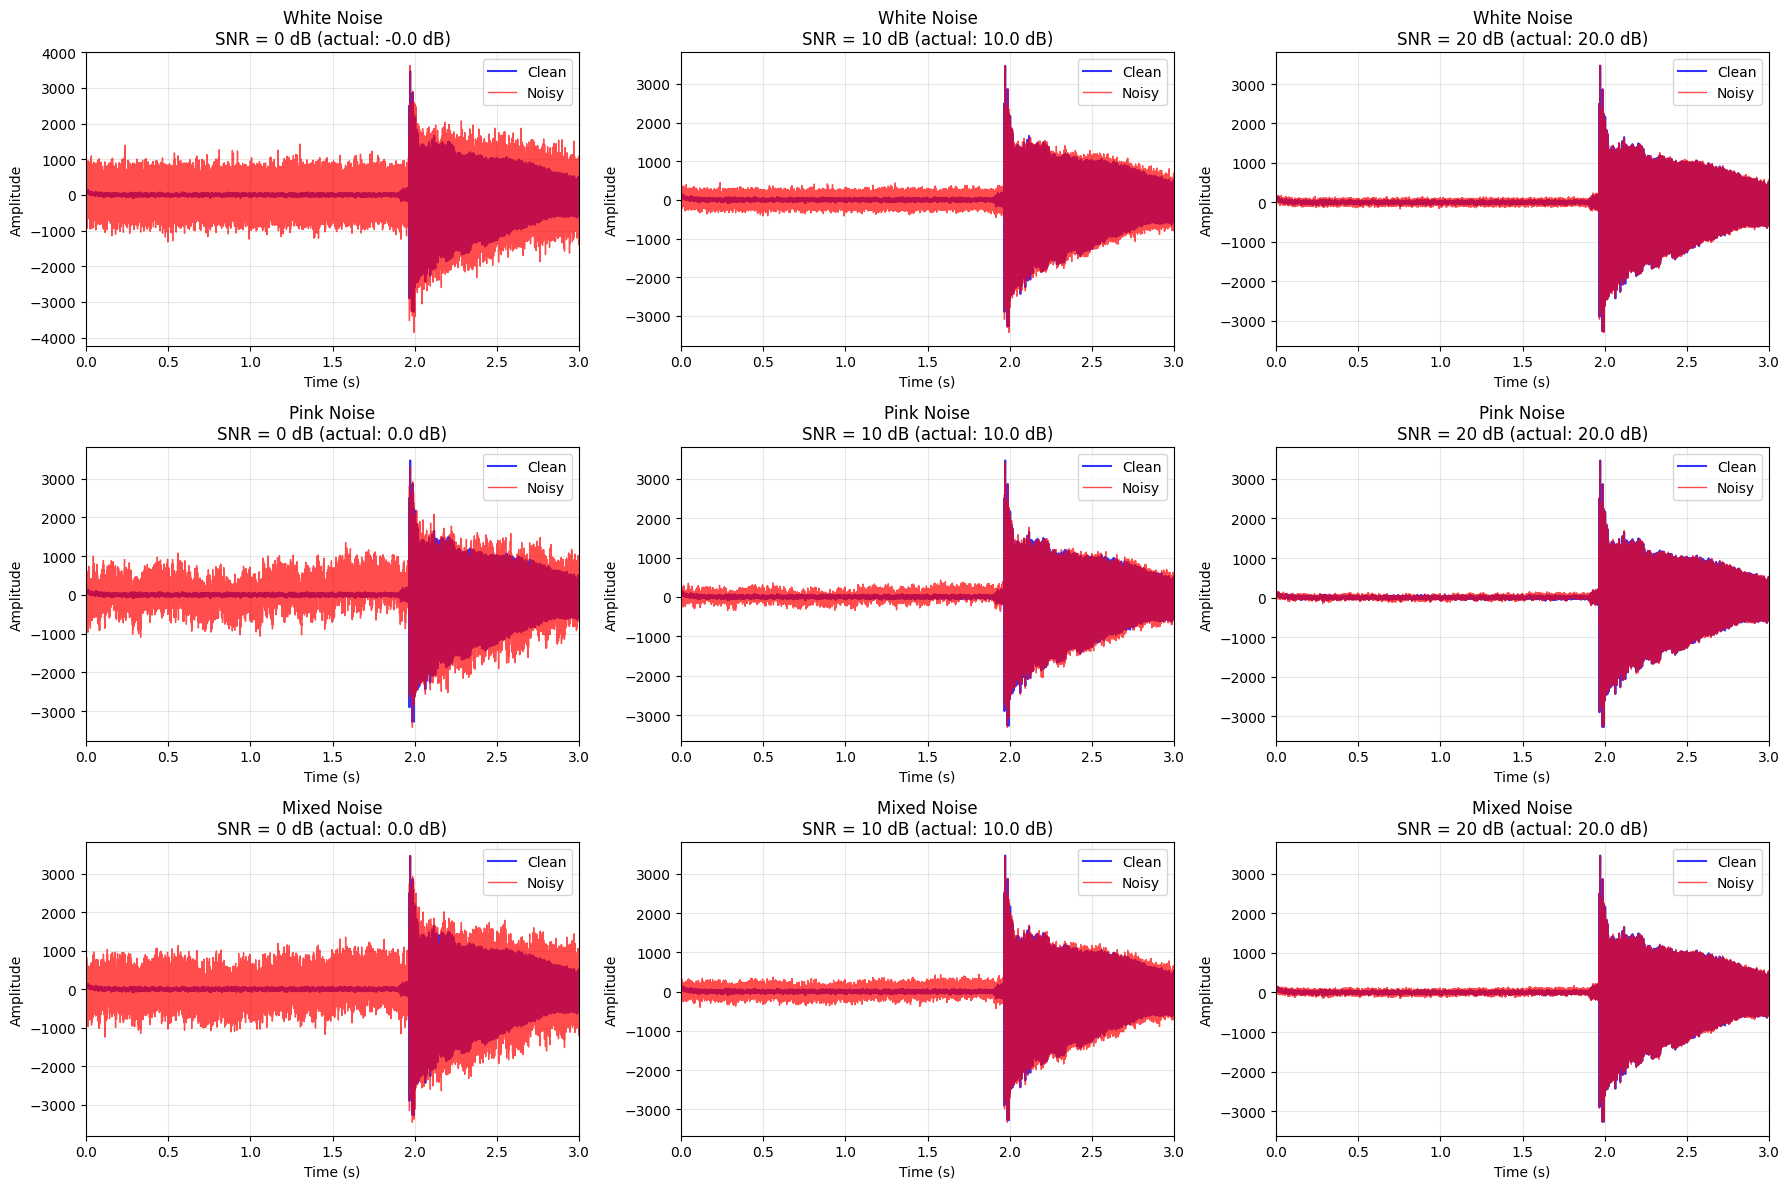

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

snr_levels_to_show = target_snrs
plot_duration = 3.0
plot_samples = int(plot_duration * fs_clean)
time_axis = np.arange(plot_samples) / fs_clean

for noise_idx, noise_type in enumerate(noise_types):
    for snr_idx, snr in enumerate(snr_levels_to_show):
        ax = axes[noise_idx, snr_idx]
        noisy_data = noisy_versions[noise_type][snr]
        noisy_signal = noisy_data['noisy_signal']
        actual_snr = noisy_data['actual_snr']
        
        ax.plot(time_axis, clean_signal[:plot_samples], 'b-', 
                linewidth=1.5, alpha=0.8, label='Clean')
        ax.plot(time_axis, noisy_signal[:plot_samples], 'r-', 
                linewidth=1, alpha=0.7, label='Noisy')
        
        ax.set_title(f'{noise_type} Noise\nSNR = {snr} dB (actual: {actual_snr:.1f} dB)')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_xlim(0, plot_duration)

plt.tight_layout()
plt.show()

We can notice that the larger SNR, the less influence noise has to the original signal. On the other hand for the $SNR = 0dB$, the original noise signal is added to the clean signal, which disturbs it quite a lot.

STFT Analysis

- Window: Hann window
- Window length: L = 1024 samples 
- Frequency domain size: M = L = 1024 
- Overlap: 50% (hop length = L/2 = 512)
- Zero padding: None (M = L)

In [7]:
window_length = 1024 
hop_length = window_length // 2 
nfft = window_length 

f_clean, t_clean, X_clean = stft(clean_signal, 
                                 fs=fs_clean,
                                 window='hann',
                                 nperseg=window_length,
                                 noverlap=window_length-hop_length,
                                 nfft=nfft,
                                 return_onesided=True)

stft_noisy_versions = {}

for noise_type in noise_types:
    stft_noisy_versions[noise_type] = {}
    for snr in target_snrs:
        noisy_signal = noisy_versions[noise_type][snr]['noisy_signal']
        
        f_noisy, t_noisy, X_noisy = stft(noisy_signal,
                                        fs=fs_clean,
                                        window='hann',
                                        nperseg=window_length,
                                        noverlap=window_length-hop_length,
                                        nfft=nfft,
                                        return_onesided=True)
        
        stft_noisy_versions[noise_type][snr] = {
            'frequencies': f_noisy,
            'times': t_noisy,
            'stft': X_noisy,
            'magnitude': np.abs(X_noisy),
            'phase': np.angle(X_noisy)
        }

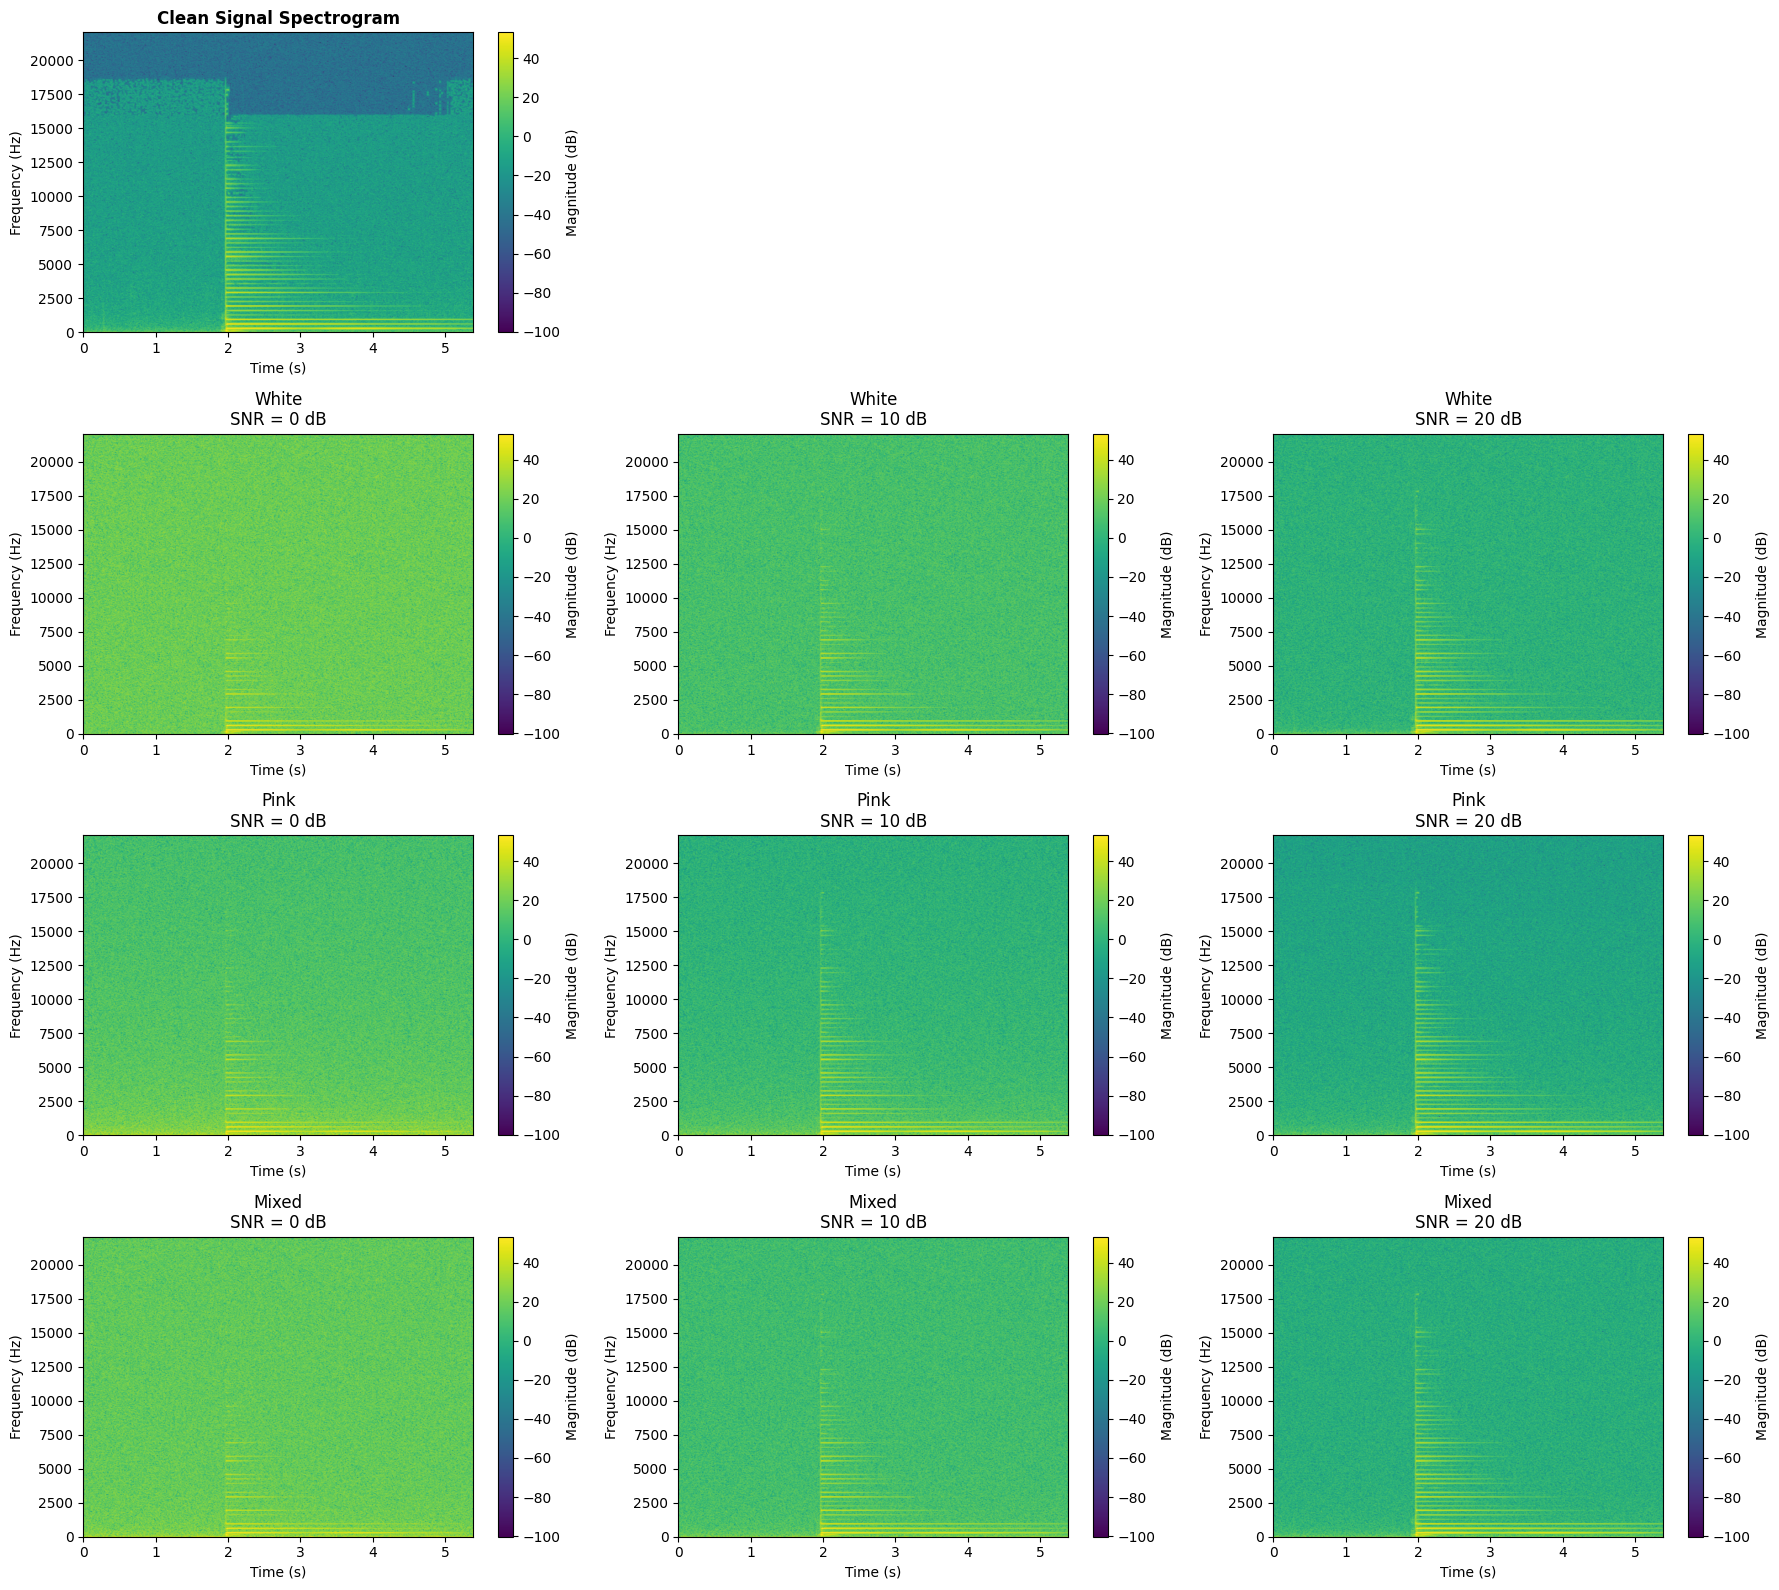

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))

X_clean_mag = np.abs(X_clean)
X_clean_db = 20 * np.log10(X_clean_mag + 1e-10)  

im_clean = axes[0, 0].pcolormesh(t_clean, f_clean, X_clean_db, shading='gouraud', cmap='viridis')
axes[0, 0].set_title('Clean Signal Spectrogram', fontweight='bold')
axes[0, 0].set_ylabel('Frequency (Hz)')
axes[0, 0].set_xlabel('Time (s)')
plt.colorbar(im_clean, ax=axes[0, 0], label='Magnitude (dB)')

axes[0, 1].set_visible(False)
axes[0, 2].set_visible(False)

for noise_idx, noise_type in enumerate(noise_types):
    for snr_idx, snr in enumerate(target_snrs):
        row = noise_idx + 1 
        col = snr_idx
        
        X_noisy_mag = stft_noisy_versions[noise_type][snr]['magnitude']
        X_noisy_db = 20 * np.log10(X_noisy_mag + 1e-10)
        
        im = axes[row, col].pcolormesh(t_clean, f_clean, X_noisy_db, 
                                      shading='gouraud', cmap='viridis',
                                      vmin=X_clean_db.min(), vmax=X_clean_db.max())
        axes[row, col].set_title(f'{noise_type}\nSNR = {snr} dB')
        axes[row, col].set_ylabel('Frequency (Hz)')
        axes[row, col].set_xlabel('Time (s)')
        
        plt.colorbar(im, ax=axes[row, col], label='Magnitude (dB)')

plt.tight_layout()
plt.show()

Hard thresholding and spectral subtraction:

In [9]:
def estimate_noise_psd(noise_stft): #check
    noise_power = np.mean(np.abs(noise_stft)**2, axis=1) 
    return noise_power

def hard_thresholding(noisy_stft, noise_psd, lambda_param=2.0):
    threshold = lambda_param * np.sqrt(noise_psd)[:, np.newaxis] 
    
    magnitude = np.abs(noisy_stft)
    
    mask = magnitude > threshold
    denoised_stft = noisy_stft * mask 
    
    return denoised_stft, mask

def spectral_subtraction(noisy_stft, noise_psd, lambda_param=2.0):
    magnitude_squared = np.abs(noisy_stft)**2
  
    subtraction_factor = lambda_param**2 * noise_psd[:, np.newaxis] / magnitude_squared

    gain = np.maximum(1 - subtraction_factor, 0.1)
    denoised_stft = noisy_stft * gain
    
    return denoised_stft, gain

def denoise_signal(noisy_signal, noise_psd, method='hard', lambda_param=2.0, 
                  window_length=1024, hop_length=512):

    f, t, noisy_stft = stft(noisy_signal, 
                           fs=fs_clean,
                           window='hann',
                           nperseg=window_length,
                           noverlap=window_length-hop_length,
                           nfft=window_length,
                           return_onesided=True)
    
    if method == 'hard':
        denoised_stft, processing_info = hard_thresholding(noisy_stft, noise_psd, lambda_param)
    elif method == 'spectral':
        denoised_stft, processing_info = spectral_subtraction(noisy_stft, noise_psd, lambda_param)
    else:
        raise ValueError("Method must be 'hard' or 'spectral'")
    
    _, denoised_signal = istft(denoised_stft,
                              fs=fs_clean,
                              window='hann',
                              nperseg=window_length,
                              noverlap=window_length-hop_length,
                              nfft=window_length,
                              input_onesided=True)
    
    return denoised_signal, denoised_stft, processing_info

In [13]:

denoising_methods = ['hard', 'spectral']
lambda_values = [1.5, 2.0, 3.0]

denoised_results = {}

for noise_type in noise_types:
    denoised_results[noise_type] = {}
    
    for snr in target_snrs:
        denoised_results[noise_type][snr] = {}
        noisy_signal = noisy_versions[noise_type][snr]['noisy_signal']
        added_noise = noisy_versions[noise_type][snr]['added_noise']
        
        _, _, noise_stft = stft(added_noise,
                               fs=fs_clean,
                               window='hann',
                               nperseg=window_length,
                               noverlap=window_length-hop_length,
                               nfft=window_length,
                               return_onesided=True)
        
        noise_psd = estimate_noise_psd(noise_stft)
        

        
        for method in denoising_methods:
            denoised_results[noise_type][snr][method] = {}
            
            for lambda_param in lambda_values:

                denoised_signal, denoised_stft, processing_info = denoise_signal(
                    noisy_signal, noise_psd, method, lambda_param,
                    window_length, hop_length
                )
                
                denoised_snr = calculate_snr(clean_signal, denoised_signal)
                improvement = denoised_snr - noisy_versions[noise_type][snr]['actual_snr']
                
            
                denoised_results[noise_type][snr][method][lambda_param] = {
                    'denoised_signal': denoised_signal,
                    'denoised_stft': denoised_stft,
                    'processing_info': processing_info,
                    'denoised_snr': denoised_snr,
                    'snr_improvement': improvement,
                    'noise_psd': noise_psd
                }

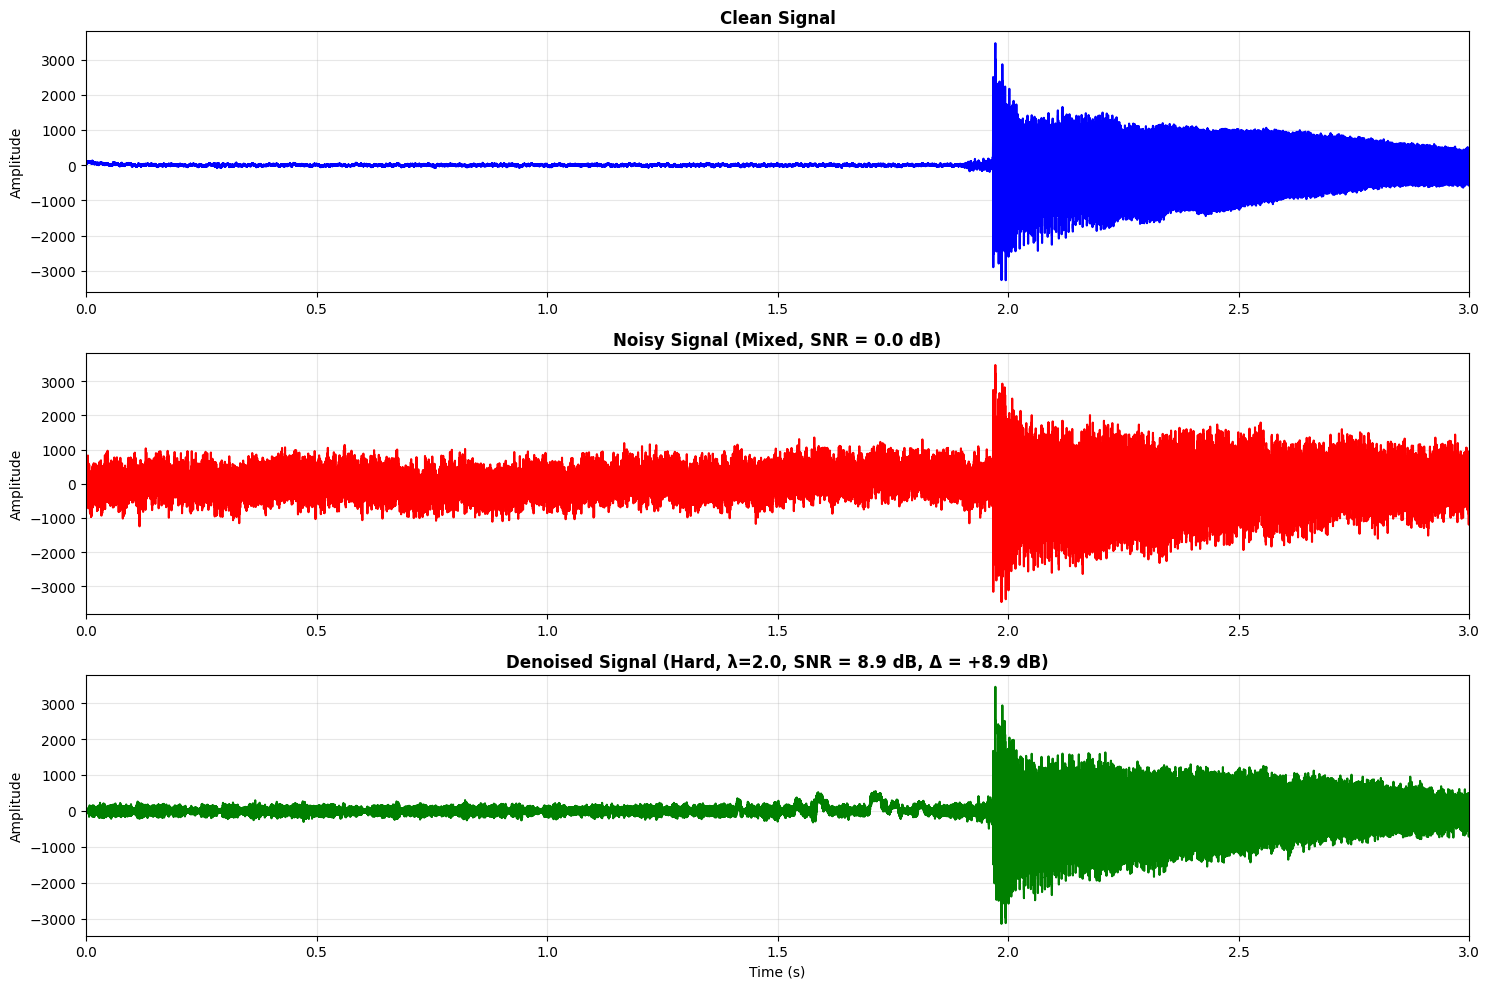

In [ ]:

def plot_denoising_comparison(noise_type, snr, method, lambda_param, plot_duration=3.0):
    clean_sig = clean_signal
    noisy_sig = noisy_versions[noise_type][snr]['noisy_signal']
    denoised_sig = denoised_results[noise_type][snr][method][lambda_param]['denoised_signal']

    plot_samples = int(plot_duration * fs_clean)
    time_axis = np.arange(plot_samples) / fs_clean

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    
    axes[0].plot(time_axis, clean_sig[:plot_samples], 'b-', linewidth=1.5)
    axes[0].set_title('Clean Signal', fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, plot_duration)
    
    original_snr = noisy_versions[noise_type][snr]['actual_snr']
    axes[1].plot(time_axis, noisy_sig[:plot_samples], 'r-', linewidth=1.5)
    axes[1].set_title(f'Noisy Signal ({noise_type}, SNR = {original_snr:.1f} dB)', fontweight='bold')
    axes[1].set_ylabel('Amplitude')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, plot_duration)
    
    denoised_snr = denoised_results[noise_type][snr][method][lambda_param]['denoised_snr']
    improvement = denoised_results[noise_type][snr][method][lambda_param]['snr_improvement']
    axes[2].plot(time_axis, denoised_sig[:plot_samples], 'g-', linewidth=1.5)
    axes[2].set_title(f'Denoised Signal ({method.capitalize()}, λ={lambda_param}, SNR = {denoised_snr:.1f} dB, Δ = {improvement:+.1f} dB)', 
                     fontweight='bold')
    axes[2].set_ylabel('Amplitude')
    axes[2].set_xlabel('Time (s)')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_xlim(0, plot_duration)
    
    plt.tight_layout()
    plt.show()

noise_type = 'Mixed'
snr = 0
lambda_param = 2.0

for method in denoising_methods:
    plot_denoising_comparison(noise_type, snr, method, lambda_param)
    result = denoised_results[noise_type][snr][method][lambda_param]

In [ ]:
# Comprehensive results visualization
fig, axes = plt.subplots(len(noise_types), len(target_snrs), figsize=(18, 12))

for noise_idx, noise_type in enumerate(noise_types):
    for snr_idx, snr in enumerate(target_snrs):
        ax = axes[noise_idx, snr_idx]
        
        # Prepare data for plotting
        x_labels = []
        snr_improvements = []
        colors = []
        
        for method in denoising_methods:
            for lambda_param in lambda_values:
                result = denoised_results[noise_type][snr][method][lambda_param]
                improvement = result['snr_improvement']
                
                label = f"{method[:4]}-λ{lambda_param}"
                x_labels.append(label)
                snr_improvements.append(improvement)
                
                # Color coding: hard = blue, spectral = orange
                colors.append('steelblue' if method == 'hard' else 'coral')
        
        # Create bar plot
        bars = ax.bar(range(len(x_labels)), snr_improvements, color=colors, alpha=0.7)
        
        # Add value labels on bars
        for i, (bar, val) in enumerate(zip(bars, snr_improvements)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}',
                   ha='center', va='bottom' if height >= 0 else 'top',
                   fontsize=8)
        
        # Formatting
        ax.set_title(f'{noise_type} Noise, SNR={snr}dB', fontweight='bold', fontsize=10)
        ax.set_xlabel('Method-λ', fontsize=9)
        ax.set_ylabel('SNR Improvement (dB)', fontsize=9)
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Hard Thresholding'),
    Patch(facecolor='coral', alpha=0.7, label='Spectral Subtraction')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
          bbox_to_anchor=(0.5, 0.98), fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Print summary table
print("\n" + "="*100)
print("DENOISING PERFORMANCE SUMMARY")
print("="*100)
print(f"{'Noise Type':<12} {'SNR (dB)':<10} {'Method':<12} {'Lambda':<8} {'Original SNR':<14} {'Denoised SNR':<14} {'Improvement':<12}")
print("-"*100)

for noise_type in noise_types:
    for snr in target_snrs:
        original_snr = noisy_versions[noise_type][snr]['actual_snr']
        for method in denoising_methods:
            for lambda_param in lambda_values:
                result = denoised_results[noise_type][snr][method][lambda_param]
                denoised_snr = result['denoised_snr']
                improvement = result['snr_improvement']
                
                print(f"{noise_type:<12} {snr:<10} {method:<12} {lambda_param:<8.1f} {original_snr:<14.2f} {denoised_snr:<14.2f} {improvement:+12.2f}")
print("="*100)

## Parameter discussion

### Lambda ($\lambda$) Parameter

The threshold multiplier $\lambda$ controls the aggressiveness of denoising.

#### Hard Thresholding

The threshold is computed as:
$$\text{threshold} = \lambda \sqrt{S_n[\nu]}$$

where $S_n[\nu]$ is the noise power spectral density. The denoised STFT is:
$$\hat{X}[\tau, \nu] = \begin{cases} 
Y[\tau, \nu] & \text{if } |Y[\tau, \nu]| > \lambda \sqrt{S_n[\nu]} \\
0 & \text{if } |Y[\tau, \nu]| \leq \lambda \sqrt{S_n[\nu]}
\end{cases}$$

- **Higher $\lambda$**: More conservative, preserves more coefficients (less denoising, retains signal details)
- **Lower $\lambda$**: More aggressive, zeros more coefficients (stronger denoising, may lose signal information)

#### Spectral Subtraction

The gain function is computed as:
$$g[\tau, \nu] = \max\left(1 - \frac{\lambda^2 S_n[\nu]}{|Y[\tau, \nu]|^2}, 0.1\right)$$

The denoised STFT is:
$$\hat{X}[\tau, \nu] = Y[\tau, \nu] \cdot g[\tau, \nu]$$

- **Higher $\lambda$**: Subtracts more noise power (more aggressive denoising)
- **Lower $\lambda$**: Subtracts less noise power (more conservative)
- Minimum gain floor of 0.1 prevents complete signal suppression

### STFT Parameters

- **Window type**: Hann window $w[n] = 0.5 - 0.5\cos(2\pi n / L)$ - reduces spectral leakage
- **Window length**: $L = 1024$ samples - determines the time-frequency resolution tradeoff (longer = better frequency resolution, worse time resolution)
- **Hop length**: $a = L/2 = 512$ samples (50% overlap) - controls frame overlap, larger overlap gives smoother reconstruction but more computation is required.
- **FFT size**: $M = L = 1024$ - sets the frequency resolution without zero-padding
- **Sampling rate**: $f_s = 44100$ Hz - standard audio sampling rate